### Overview
This notebook demonstrates preprocessing and basic analysis of RAD7 data series (from `.r7raw` files), utilizing packages from `src/`.

### 1. Load data 
* Load `.r7raw` file into a Dataframe
* Check the cycle length and variable units
* Select columns to analyze

### 2. Saving data to file (example)
* Save data to `.parquet` file
* Load the file back as a Dataframe

### 3. Simple plotting
* Plot radon concentration vs. time

In [17]:
# Imports
# RAD7 data processing packages
from src.utils import (
    parse_raw_data
)

# Data manipulation
import pandas as pd

# Plotting
import matplotlib.pyplot as plt


### Load and preview data

In [ ]:
# Get r7raw data file to process.
raw_data_path = "example_data/RAD7 04261 Data 2026-01-28.r7raw"

# Parse the data into an organized table.
rad7_run_df = parse_raw_data(raw_data_path)

# The r7raw files do not include column headers, and some columns are byte codes.
# parse_raw_data reads the byte codes and expands them into labeled columns, and consolidates the datetime information into a single Timestamp column. 
# No other processing is done, such as dropping rows with certain values, etc.

In [ ]:
# Check dataframe columns to see what data there is in the file.
rad7_run_df.columns

Index(['Total Counts', 'Live Time', '% of total counts in win. A',
       '% of total counts in win. B', '% of total counts in win. C',
       '% of total counts in win. D', 'High Voltage Level',
       'High Voltage Duty Cycle', 'Temperature',
       'Relative humidity of sampled air', 'Leakage Current',
       'Battery Voltage', 'Pump Current', 'Radon concentration',
       'Radon concentration uncertainty', 'Timestamp', 'Pump State',
       'Thoron On', 'Measurement Type', 'Auto Mode', 'Sniff Mode',
       'Concentration Unit', 'Temperature Unit'],
      dtype='str')

In [20]:
# Check the cycle length (time interval between measurements) and concentration units
# This is metadata to help label plots later on.
rad7_run_df[["Timestamp", "Concentration Unit"]].head(10)

# Simply add more column names to the list inside the double brackets to preview more data.

,Timestamp,Concentration Unit
0,2026-01-14 17:27:00,Total Counts
1,2026-01-14 17:47:00,Total Counts
2,2026-01-14 18:07:00,Total Counts
3,2026-01-14 18:27:00,Total Counts
4,2026-01-14 18:47:00,Total Counts
5,2026-01-14 19:07:00,Total Counts
6,2026-01-14 19:27:00,Total Counts
7,2026-01-14 19:47:00,Total Counts
8,2026-01-14 20:07:00,Total Counts
9,2026-01-14 20:27:00,Total Counts


### Select data columns of importance

In [21]:
# Choose which columns you want to analyze or save instead of hauling around all the extra data columns.
rad_conc_df = rad7_run_df[[
    'Timestamp', 
    'Radon concentration', 
    'Radon concentration uncertainty'
]].copy()
# rad_conc_df now only holds these 3 columns instead of the full 23.

### Saving & loading the preprocessed data file

In [ ]:
# Skip this cell if not wanting to save off this data to a file, and you want to go straight to plotting.

# Save it to a parquet file (example)
save_path = "rad7_run_01282026.parquet"
rad_conc_df.to_parquet(save_path, index=False)   # The index of the dataframe is just integer-numbering that we dont care to save as a column in the file.

# Load it back as a dataframe
rad_conc_df = pd.read_parquet(save_path)

### Plotting data

In [ ]:
# Set timestamp as the dataframe Index (for easier plotting and re-binning).
rad_conc_df.set_index("Timestamp", inplace=True)   

# Note: To save a dataframe WITH the index (set as a column you care about, like Timestamp), 
# make sure to do index=True when saving to parquet.

# Inspect the column names if you want to access columns in the dataframe by name (you can copy and paste the column names like as below)
rad_conc_df.columns

# Note: Timestamp is no longer a listed column because it is the Index of the dataframe: it is the row labels. 

Index(['Radon concentration', 'Radon concentration uncertainty'], dtype='str')

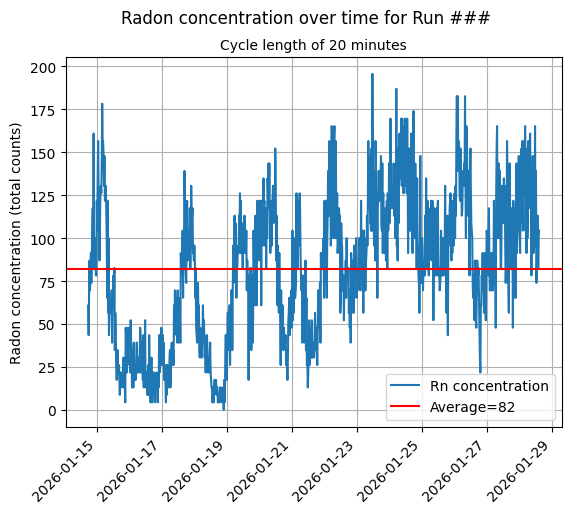

In [ ]:
# Plotting
# Get radon concentration series (column at position 0). Column name can also be used.
radon_conc_arr = rad_conc_df.iloc[:, 0]
# radon_conc_arr = radon_df["Radon concentration (Total Counts)"]   # Equivalent to above, with copied column name from previous output

# Plot radon concentration vs time.
plt.plot(
    rad_conc_df.index,      # x-axis: Timestamp
    radon_conc_arr,         # y-axis: Radon concentration
    label="Rn concentration"
)

# Add a horizontal line indicating the average 
avg_rad_conc = radon_conc_arr.mean()        # Calculate average radon concentration
avg_rad_conc = int(avg_rad_conc.round(1))   # Round to nearest integer
plt.axhline(
    y=avg_rad_conc, 
    color='r', 
    label=f'Average={avg_rad_conc}'
)

# Formatting and labelling the plot
plt.xticks(rotation=45, ha='right')   # Tilt timestamp labels
plt.ylabel(f"{rad_conc_df.columns[0]} (total counts)")   # Name of radon concentration column (make sure to update your units)
plt.suptitle("Radon concentration over time for Run ###")
plt.title("Cycle length of 20 minutes", fontsize=10)
plt.grid(True)   # Add grid lines
plt.legend()     # Show legend (line labels)
plt.show()

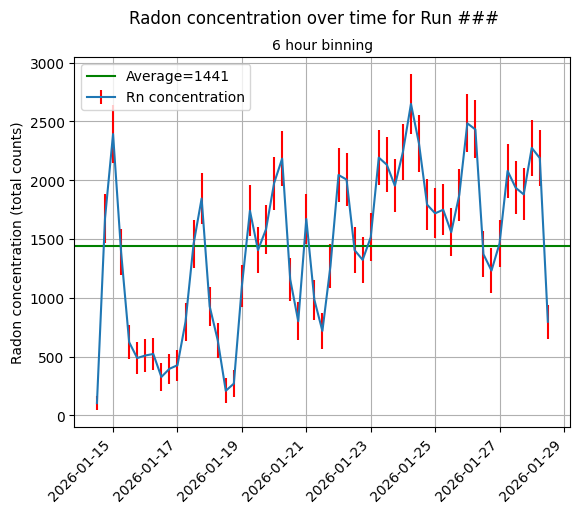

In [ ]:
# Plot radon concentration *with error bars*
# Let's also rebin the counts for fun, we can also see the error bars better this way.

# If your concentration unit is total counts, it is straightforward to rebin
# -> Counts just add within new cycle length
# -> Uncertainties are just square root of new counts (Poissonian)
rebinned_df = rad_conc_df["counts"].resample("6h").sum().to_frame()
rebinned_df["uncertainty"] = rebinned_df["counts"] ** 0.5

# If counts are not Poissonian -> add the uncertainties that already exist in quadrature.
# rebinned_df = rad_conc_df.resample("6h").agg(
#     counts=("Radon concentration", "sum"),
#     uncertainty=("Radon concentration uncertainty", lambda x: (x**2).sum()**0.5)  # Adding uncertainties in quadrature
# )

# Get the counts and uncertainity series.
radon_conc_arr = rebinned_df.iloc[:, 0]
uncertainty = rebinned_df.iloc[:, 1]

# Errorbar plotting function.
plt.errorbar(
    rebinned_df.index,          # x-axis: Timestamps
    radon_conc_arr,             # y-axis: Radon concentration
    yerr=uncertainty,           # y-uncertainty
    label="Rn concentration",
    ecolor='r'
)

# Add a horizontal line indicating the average 
avg_rad_conc = radon_conc_arr.mean()        # Calculate average radon concentration
avg_rad_conc = int(avg_rad_conc.round(1))   # Round to nearest integer
plt.axhline(                
    y=avg_rad_conc, 
    color='g', 
    label=f'Average={avg_rad_conc}'
)

# Formatting and labelling the plot
plt.xticks(rotation=45, ha='right')   # Tilt timestamp labels
plt.ylabel(f"{rad_conc_df.columns[0]} (total counts)")   # Name of radon concentration column (make sure to update your units)
plt.suptitle("Radon concentration over time for Run ###")
plt.title("6 hour binning", fontsize=10)
plt.grid(True)   # Add grid lines
plt.legend()     # Show legend (line labels)
plt.show()